In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as mt
import matplotlib.pyplot as plt
import os

In [9]:
source_dir = "/home/vincent/Documenten/BachelorsProject/ft_scale/"
target_dir = "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/results/ft_scale/"

# Training set size per dataset:
ds_sizes = {
    "100" : 6336,
    "056" : 3554,
    "032" : 1995,
    "018" : 1113,
    "010" : 624,
}

models = {
    "vit_b_16": {"vit": True},
    "swin_b": {"vit": True},
    "beit_b_16": {"vit": True},
    "deit_b_16": {"vit": True},
    "vgg19": {"vit": False},
    "resnet50": {"vit": False},
    "efficientnetv2_m": {"vit": False},
    "convnext_b": {"vit": False}
}

In [10]:
def getArrays(csv_predictions: str, csv_confusion: str):
    """Returns numpy arrays we can work with using scikit-learn"""
    df_pred = pd.read_csv(csv_predictions)
    df_conf = pd.read_csv(csv_confusion)

    true_y = df_pred["actual_idx"].to_numpy()
    pred_y = df_pred[df_conf.columns[1:]].to_numpy()

    # Rows gives actual, columns prediction
    conf = df_conf[df_conf.columns[1:]].to_numpy().T

    return true_y, pred_y, conf

In [11]:
def accFromCsv(csv_predictions):
    csv_confusion = csv_predictions.replace("predictions", "confusion")
    true_y, pred_y, _ = getArrays(csv_predictions, csv_confusion)
    pred_y_max = np.argmax(pred_y, axis=1)
    return { "acc": mt.accuracy_score(true_y, pred_y_max),
             "b_acc": mt.balanced_accuracy_score(true_y, pred_y_max),
             "top3_acc": mt.top_k_accuracy_score(true_y, pred_y, k=3),
             "top5_acc": mt.top_k_accuracy_score(true_y, pred_y, k=5)}

In [12]:
# Creating a long-form dataframe with all datapoints
df = pd.DataFrame(columns=["ds_num", "ds_size", "model", "acc", "b_acc", "top3_acc", "top5_acc"])

for file in os.scandir(source_dir):
    if file.is_file() and "test_predictions.csv" in file.name:
        row = accFromCsv(file.path)
        row["model"] = [m for m in models if m in file.name][0]
        row["ds_size"] = [s for s in ds_sizes if s in file.name][0]
        
        # Gave dataset0 different naming, so have to treat it different than 1 to 4
        if "_" + row["ds_size"] not in file.name:
            row["ds_num"] = 0
        else:
            s = "scale"
            row["ds_num"] = int(file.name[file.name.find(s) + len(s)])
        
        row["ds_size"] = int(row["ds_size"])

        row = pd.DataFrame(row, index=[0])
        df = pd.concat([df, row], ignore_index=True)

df.sort_values(["ds_num", "ds_size", "model"], inplace=True, ignore_index=True)
df

,ds_num,ds_size,model,acc,b_acc,top3_acc,top5_acc
0,0,10,beit_b_16,0.855422,0.832222,0.975904,0.987952
1,0,10,convnext_b,0.86747,0.835556,0.975904,1.0
2,0,10,deit_b_16,0.879518,0.834444,0.963855,0.987952
3,0,10,efficientnetv2_m,0.795181,0.768889,0.963855,1.0
4,0,10,resnet50,0.86747,0.831111,0.963855,0.987952
...,...,...,...,...,...,...,...
195,4,100,efficientnetv2_m,0.943538,0.932736,0.991217,0.992472
196,4,100,resnet50,0.944793,0.9286,0.986198,0.991217
197,4,100,swin_b,0.942284,0.929003,0.996236,0.996236
198,4,100,vgg19,0.927227,0.910016,0.986198,0.994981


In [26]:
df.to_csv(os.path.join(target_dir, "all_results.csv"), index=False)

In [13]:
for model in models:
    for size in ds_sizes:
        tmpDf = df[(df.model == model) & (df.ds_size == int(size))]
        models[model][size] = {
            "acc_mean": tmpDf["acc"].mean(),
            "acc_std": tmpDf["acc"].std(),
            "b_acc_mean": tmpDf["b_acc"].mean(),
            "b_acc_std": tmpDf["b_acc"].std()
        }
        models[model][size]["acc_top"] = models[model][size]["acc_mean"] +\
            models[model][size]["acc_std"] / len(tmpDf) ** .5
        models[model][size]["acc_bottom"] = models[model][size]["acc_mean"] -\
            models[model][size]["acc_std"] / len(tmpDf) ** .5
        
        models[model][size]["b_acc_top"] = models[model][size]["b_acc_mean"] +\
            models[model][size]["b_acc_std"] / len(tmpDf) ** .5
        models[model][size]["b_acc_bottom"] = models[model][size]["b_acc_mean"] -\
            models[model][size]["b_acc_std"] / len(tmpDf) ** .5

In [28]:
import pprint
pprint.pprint(models)

{'beit_b_16': {'010': {'acc_bottom': 0.792650902117781,
                       'acc_mean': 0.8168674698795181,
                       'acc_std': 0.05414989169697407,
                       'acc_top': 0.8410840376412552,
                       'b_acc_bottom': 0.7512206851540116,
                       'b_acc_mean': 0.7793333333333333,
                       'b_acc_std': 0.06286179235649904,
                       'b_acc_top': 0.807445981512655},
               '018': {'acc_bottom': 0.8174333993212388,
                       'acc_mean': 0.8301369863013699,
                       'acc_std': 0.02840608404565438,
                       'acc_top': 0.842840573281501,
                       'b_acc_bottom': 0.792901515125137,
                       'b_acc_mean': 0.8101693121693122,
                       'b_acc_std': 0.038611968012445694,
                       'b_acc_top': 0.8274371092134875},
               '032': {'acc_bottom': 0.87414390558304,
                       'acc_mean': 0.884375,
 

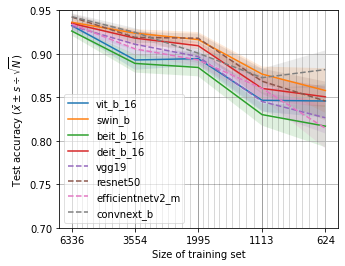

In [14]:
# Plotting mean accuracies of the 5 trials per scale:
keys = [key for key in ds_sizes]
x = [ds_sizes[key] for key in keys]

num_interp_points = 10
for idx in range(len(x) - 1):
    interp = np.linspace(x[idx], x[idx+1], num_interp_points, endpoint=False)
    for p in interp:
        plt.axvline(p, color='black', alpha=0.3, linewidth=0.5)

for model in models:
    y = [models[model][key]["acc_mean"] for key in keys]
    ytop = [models[model][key]["acc_top"] for key in keys]
    ybott = [models[model][key]["acc_bottom"] for key in keys]
    ls = "-" if models[model]["vit"] else "--"
    plt.plot(x, y, label=model, linestyle=ls)
    plt.fill_between(x, y1=ybott, y2=ytop, alpha=0.15)

plt.legend(framealpha=0.6)
plt.grid()
plt.xlabel("Size of training set")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.minorticks_off()

plt.xticks(x, [str(idx) for idx in x])

plt.ylabel(r"Test accuracy ($\bar{x} \pm s \div \sqrt{N}$)")
plt.ylim(top=0.95, bottom=0.7)

fig = plt.gcf()
fig.set_size_inches(5, 4)

plt.savefig(os.path.join(target_dir, "mean_accuracy.svg"), format="svg")
# plt.show()

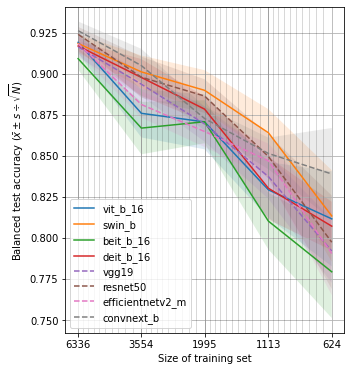

In [30]:
# Plotting mean **balanced** accuracies of the 5 trials per scale:
keys = [key for key in ds_sizes]
x = [ds_sizes[key] for key in keys]

num_interp_points = 10
for idx in range(len(x) - 1):
    interp = np.linspace(x[idx], x[idx+1], num_interp_points, endpoint=False)
    for p in interp:
        plt.axvline(p, color='black', alpha=0.3, linewidth=0.5)

for model in models:
    y = [models[model][key]["b_acc_mean"] for key in keys]
    ytop = [models[model][key]["b_acc_top"] for key in keys]
    ybott = [models[model][key]["b_acc_bottom"] for key in keys]
    ls = "-" if models[model]["vit"] else "--"
    plt.plot(x, y, label=model, linestyle=ls)
    plt.fill_between(x, y1=ybott, y2=ytop, alpha=0.15)

plt.legend()
plt.grid()
plt.xlabel("Size of training set")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.minorticks_off()

plt.xticks(x, [str(idx) for idx in x])

plt.ylabel(r"Balanced test accuracy ($\bar{x} \pm s \div \sqrt{N}$)")

fig = plt.gcf()
fig.set_size_inches(5, 6)

plt.savefig(os.path.join(target_dir, "mean_balanced_accuracy.svg"), format="svg")
# plt.show()